# Across-trials testing with [GLHMM toolbox](https://github.com/vidaurre/glhmm)
In this tutorial, we explore how to implement across-trials testing using the [GLHMMS toolbox](https://github.com/vidaurre/glhmm), part of the paper [The Gaussian-Linear Hidden Markov Model: a Python Package](https://arxiv.org/abs/2312.07151). This test is designed to assess differences between trials within one or more experimental sessions, making it ideal for analyzing trial-by-trial variability within a session.

In real-world scenarios, one would typically fit a Hidden Markov Model (HMM) to actual data. However, for the purpose of illustrating the statistical testing concept, we use synthetic data for both the brain data ($D$) and the behavioural data ($R$) in the ```across_trials_within_session``` test. For this demonstration, we specifically use a time-delayed embedding HMM (TDE-HMM), showcasing its application within the testing framework.

The synthetic data is generated using the toolbox [Genephys](https://github.com/vidaurre/genephys), developed by [Vidaurre in 2023](https://elifesciences.org/reviewed-preprints/87729). Genephys enables the simulation of electrophysiological data within the context of psychometric experiments. It can create scenarios where a subject is exposed to one or multiple stimuli while recording EEG or MEG data.

For this tutorial:

* The Brain data ($D$) simulates EEG or MEG recordings with 16 channels, measured across multiple trials and sessions. Each trial consists of 250 timepoints.
* The behavioural data ($R$) marks when a subject observes different types of stimuli, such as animate versus inanimate objects.
This setup gives a detailed analysis of how brain activity patterns vary across stimulus conditions and trials.


While data preparation requires some explanation, running the ```across_trials_within_session``` test is straightforward. Simply provide the input variables ($D$ and $R$) and specify the method for the analysis.

**Note:** Due to rendering issues when viewing this notebook through github, internal links, like the table of contents, may not work correctly. To ensure that the notebook renders correctly, you can view it through [this link](https://nbviewer.org/github/vidaurre/glhmm/blob/main/docs/notebooks/Testing_across_trials_within_session.ipynb).

Authors: Nick Yao Larsen <nylarsen@cfin.au.dk>


## Table of Contents
1. [Load and prepare data](#load-data)
    * [Look at data](#look-data)
    * [Prepare data for HMM](#prep_hmm)
2. [Load or initialise and train TDE-HMM](#load_hmm)
    * [Data restructuring](#data-recon)
3. [Across-trials within session testing](#across_trials)
    * [Across-trials within sessions testing - Multivariate](#perm-regression)
    * [Across-trials within sessions testing - Univariate](#perm-correlation)



### Install necessary packages
If you dont have the **GLHMM-package** installed, then run the following command in your terminal:

```pip install git+https://github.com/vidaurre/glhmm```

### Import libraries
Let's start by importing the required libraries and modules.

In [1]:
import numpy as np
from pathlib import Path
from glhmm import glhmm, graphics, preproc, statistics, auxiliary, io

## 1. Load and prepare data <a id="load-data"></a>
First, we'll load the synthetic data from this [folder](https://github.com/vidaurre/glhmm/tree/main/docs/notebooks/data_statistical_testing) and use the [GLHMM toolbox](https://github.com/vidaurre/glhmm) to train a classic HMM on the synthetic data that represents EEG or MEG measurements.\
Let's start by loading the essential data for this tutorial:

In [2]:
# Get the current directory
PATH_PARENT = Path.cwd()
# Path of the location of the data
PATH_DATA = PATH_PARENT / "data_statistical_testing"

# Load D data
D_trials = np.load(PATH_DATA/"D_trials.npy")
# Load R data
R_trials = np.load(PATH_DATA/"R_trials.npy")
# Load indices
idx_trials_session = np.load(PATH_DATA/"idx_trials_session.npy")
# Load indices
idx_trials = np.load(PATH_DATA/"idx_trials.npy")


print(f"Data dimension of D-session data: {D_trials.shape}")
print(f"Data dimension of R-session data: {R_trials.shape}")
print(f"Data dimension of indices for the number of trials for each session: {idx_trials_session.shape}")
print(f"Data dimension of indices: {idx_trials.shape}")

Data dimension of D-session data: (250, 1421, 16)
Data dimension of R-session data: (1421,)
Data dimension of indices for the number of trials for each session: (10, 2)
Data dimension of indices: (1421, 2)


### Look at data <a id="look-data"></a>
Now we can look at the data structure.
- D_sessions: 3D array of shape (n_timepoints, n_trials, n_features)
- R_sessions: 3D array of shape (n_trials,)
- idx_trials_session: 2D array of shape (n_sessions, 2)
- idx_trials: 2D array of shape (n_trials, 2)

```D_sessions``` represents the data collected from the subject, structured as a list with three elements: ```[250, 1421, 16]```. The first element indicates that the subject underwent measurement across 250 timepoints. The second element, 1421 corresponds to the total number of trials conducted. In this context, 10 distinct sessions were executed, each comprising 150 trials, lead up to a total of 1421 trials (150*10). Each individual trial involved the measurement of 16 channels within the EEG or MEG scanner.

```R_sessions``` categorial values of when a stimulus is prestented. It contain values of 1 and 2. 

```idx_trials_session.shape = [10, 2]``` shows the indices for the number of sessions conducted, which in this case is 10 The values in each row represent the indices for the first and last trial for a given session. As you can see the number of trials are different from each session.
```python
np.diff(idx_trials_session)
array([[129],
       [132],
       [150],
       [150],
       [150],
       [150],
       [150],
       [150],
       [111],
       [149]])
```


Lastly, we have ```idx_trials.shape = [1421, 2]```, which marks the number of trials conducted, which in this case is 1421 The values in each row represent the start and end indices for every trial. Having this index to seperate the time period for each trial is required when training a time-delay embedded HMM (TDE-HMM).

### Prepare data for HMM <a id="prep_hmm"></a>
When training a HMM, the input data must follow a specific format. The data should be organized as ((number of timepoints * number of trials), number of features). This means trials from different sessions are combined into one row. The second element represents the features, such as parcels or channels.

In our case, the initial data matrix, ```D_session```, has the shape ```[250, 1421, 16]``` (n_timepoints, n_trials, n_channels). After combining all trials, the matrix becomes ```[355250, 16]``` (timepoints * trials, channels). 

To align everything, ```R_session``` and ```idx_trials_session``` also need to be updated to match the concatenated data. The function ```get_concatenate_sessions``` automates this process by handling the trial-by-trial concatenation for each session.

**Note: it is important to use ```idx_trials_session``` for this function as the concatenation is done trial-by-trial basis for every defined session.**

In [3]:
D_con,R_con,idx_con=statistics.get_concatenate_sessions(D_trials, R_trials, idx_trials_session)
print(f"Data dimension of the concatenated D-data: {D_con.shape}")
print(f"Data dimension of the concatenated R-data: {R_con.shape}")
print(f"Data dimension of the updated time stamp indices: {idx_con.shape}")

Data dimension of the concatenated D-data: (355250, 16)
Data dimension of the concatenated R-data: (355250,)
Data dimension of the updated time stamp indices: (10, 2)


For a quick sanity check, let's verify whether the concatenation was performed correctly on ```D_trials```. We've essentially stacked up every timepoint from each trial sequentially.

To do this, we can compare a slice of our original design matrix, say ```D_trials[:, 0, :]```, with the corresponding slice in the concatenated data, ```D_con[0:250, :]```.\
If the comparison ```D_trials[:, 0, :] == D_con[0:250, :]``` holds true, we're essentially confirming that all timepoints in the first trial align perfectly with the first 250 values in our concatenated data. It's like double-checking to make sure everything lined up as expected.

In [4]:
np.array_equal(D_trials[:, 0, :], D_con[0:250, :])

True

Here, it's evident that the concatenation process has been executed accurately.

Next up, let's confirm if the values in ```idx_con``` have been appropriately updated. Each row in this matrix should represent the total count of timepoints and trials for each of the 10 sessions. 

In [5]:
idx_con

array([[     0,  32250],
       [ 32250,  65250],
       [ 65250, 102750],
       [102750, 140250],
       [140250, 177750],
       [177750, 215250],
       [215250, 252750],
       [252750, 290250],
       [290250, 318000],
       [318000, 355250]])

Indeed, each session now aligns with the number of datapoints. This means that when we pooled together the timepoints and trials, the count for each session ended up exactly as expected. It's a reassuring confirmation that our concatenation didn't miss a beat.

**NOTE: It is important to standardise your timeseries and, if necessary, apply other kinds of preprocessing before fitting the model.**\
This will be done separately for each session/subject as specified in the indices. The data provided here are already close to standardised (so the code below will not do much).

## 2. Load data or initialise and train TDE-HMM <a id="load_hmm"></a>
You can either load the ```Gamma``` values from a pretrained model or train your own model. If you prefer the former option, load the data (```Gamma_trials_tde```) from the [data_statistical_testing](https://github.com/vidaurre/glhmm/tree/main/docs/notebooks/data_statistical_testing) folder. In this example we have trained a time-delay embedded  HMM (TDE-HMM), incorporating mean and covariance parameters for 6 distinct states.
TDE-HMM calculates the covariance and then compares the covariance at different time points. If the covariances are similar, the time points are assigned to the same state; otherwise, they are assigned to different states.

If you decide to train your own TDE-HMM model, you need to prepare the dataset by adding lags that act like a sliding window. These lags capture temporal dependencies in the data and span from -n to n, passing through zero. The code below shows how to define such lags:

Once the dataset is appropriately prepared, you can proceed with training the TDE-HMM.

In [6]:
# Define the number of lags (Window size)
lag_val =list(range(-7, 8, 1))
print(lag_val)

[-7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7]


**NOTE: It is important to standardise your timeseries and, if necessary, apply other kinds of preprocessing before fitting the model.**\
This will be done separately for each session/subject as specified in the indices. The data provided here are already close to standardised (so the code below will not do much). 

In [7]:
D_con_preproc,_ = preproc.preprocess_data(D_con, idx_con, standardise=True)

We can now prepare the dataset by using the following function ```preproc.build_data_tde```, so it is ready for the TDE-HMM.\
The inputs will be the concatenated data (```D_con```), the indices that defines the running period for each trial (```idx_trials```) of the concatenated data, and the lag kernel (```lag_val```) that will run over each trial.

In [10]:
# Prepare the dataset for TDE-HMM
D_con_tde,idx_tde = preproc.build_data_tde(D_con_preproc, idx_trials,lag_val)

In [11]:
print(f"Data dimension of the concatenated TDE D-data: {D_con_tde.shape}")
print(f"Data dimension of the updated TDE time stamp indices: {idx_tde.shape}")

Data dimension of the concatenated TDE D-data: (335356, 240)
Data dimension of the updated TDE time stamp indices: (1421, 2)



The dimensions of the concatenated data (```D_con```) changed from [355250, 16] to [335356, 240] (```D_con_tde```) after applying the lag kernel.

This change is due to the defined lag kernel, which ranges from `-7` to `7`. The kernel excludes 7 data points from both the start and end of each trial, reducing the trial length from 250 time points to 236 (`250 - 14`).

With 1421 trials, the original data had `1421 * 250 = 355250` data points. After applying the lag kernel, the total is `1421 * 236 = 335356`, as seen in `D_con_tde`.

The `idx_tde` values confirm this adjustment, showing that each trial now spans 236 points, consistent with the removal of 7 data points from both ends based on the defined `lag_val`.


In [12]:
# Look at idx_tde
idx_tde

array([[     0,    236],
       [   236,    472],
       [   472,    708],
       ...,
       [334648, 334884],
       [334884, 335120],
       [335120, 335356]])

### Initialize HMM-TDE <a id="HMM-initialize"></a>
If you want to train your own HMM-TDE you need to do the following steps. First, we need to initialize the ```hmm``` object and set the hyperparameters according to our modeling preferences.

In this case, we choose not to model an interaction between two sets of variables in the HMM states, so we set ```model_beta='no'```. For our estimation, we choose ```K=6``` states. If you wish to model a different number of states, simply adjust the value of ```K```.

Our modeling approach involves representing states as Gaussian distributions with mean and a full covariance matrix. This means that each state is characterized by a mean amplitude and a functional connectivity pattern. To specify this configuration, set ```covtype='full'```. If you prefer not to model the mean, you can include ```model_mean='no'```. Optionally, you can check the hyperparameters to make sure that they correspond to how you want the model to be set up.

In [13]:
# Create an instance of the glhmm class
K = 6 # number of states
hmm = glhmm.glhmm(model_beta='no', K=K, covtype='full')
print(hmm.hyperparameters)

{'K': 6, 'covtype': 'full', 'model_mean': 'state', 'model_beta': 'no', 'dirichlet_diag': 10, 'connectivity': None, 'Pstructure': array([[ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True]]), 'Pistructure': array([ True,  True,  True,  True,  True,  True])}


### Train an HMM <a id="HMM-train"></a>
Now, let's proceed to train the TDE-HMM using the data (```D_con_tde```) and time indices (```idx_tde```).

Since in this case, we are not modeling an interaction between two sets of timeseries but opting for a "classic" HMM, we set ```X=None```. For training, ```Y``` should represent the timeseries from which we aim to estimate states (```D_con_tde```), and indices should encompass the beginning and end indices of each subject (```idx_tde```).

If you want to use the same Gamma values as used in this tutorial without training the HMM, you can just load ```Gamma_tde``` using the code below:
```python
# Get the current directory
PATH_PARENT = Path.cwd()
# Path of the location of the data
PATH_DATA = PATH_PARENT / "data_statistical_testing"
# Load Gamma data
Gamma_tde = np.load(PATH_DATA/"Gamma_trials_tde.npy")
print(f"Data dimension of Gamma-TDE: {Gamma_tde.shape}")

```

In [ ]:
Gamma_tde,Xi,FE = hmm.train(X=None, Y=D_con_tde, indices=idx_tde)

Now, checking out ```Gamma```, you'll see it's got the same number of points as the concatenated dataset (335356 ). Each column in Gamma stands for one of the six different states.

In [9]:
Gamma_tde.shape

(335356, 6)

**Reconstruct the shape of Gamma**\
To reshape Gamma back to match the original dataset, we will pad the data using the auxiliary.padGamma function. This function requires three inputs: ```Gamma```, ```T```, and ```option```.

* ```Gamma```: The state probabilities obtained from the TDE-HMM.
* ```T```: The original number of data points per trial, restored from 236 to 250. This can be computed using the ```auxiliary.get_T``` function, which takes the original indices idx_trials as input.
* ```option```: A dictionary specifying additional parameters. Since lags are used here, the key is "embeddedlags", and the value is the variable lag_val.

This process restores Gamma to align with the original trial structure, making it ready for further analysis.

In [10]:
# Get T
T = auxiliary.get_T(idx_trials)
# Define options
options ={'embeddedlags':lag_val}
Gamma =auxiliary.padGamma(Gamma_tde,
                          T,
                          options=options)

Look at Gamma

In [11]:
#Look at shape for Gamma and D_con
Gamma.shape, D_con.shape

((355250, 6), (355250, 16))

Now, you'll notice that the number of data points in both ```Gamma``` and ```D_con``` are back in sync.

Taking a closer look at the padding for the initial trial in state 1, you can observe that padding has been applied to the first 7 data points and the last 7 data points.



In [12]:
# As we can see the padding works, since the first and last 7 numbers
# has been added to the timepoints for every trial
Gamma[:10,0].round(3),Gamma[240:250,0].round(3)

(array([0.229, 0.229, 0.229, 0.229, 0.229, 0.229, 0.229, 0.   , 0.   ,
        0.   ]),
 array([0.607, 0.775, 0.783, 0.229, 0.229, 0.229, 0.229, 0.229, 0.229,
        0.229]))

## Data Restructuring <a id="data-recon"></a>

After training the HMM and obtaining the `Gamma` values, we need to restructure the data back to its original format. Instead of performing HMM-aggregated statistics, this tutorial focuses on statistical testing at each time point.

To achieve this, we use the `reconstruct_concatenated_to_3D` function. This function converts a concatenated 2D matrix into a 3D matrix. Specifically, it reshapes `Gamma` from `[355250, 6]` to `[250, 1421, 6]` (timepoints, trials, states).


In [13]:
# Reconstruct the Gamma matrix
n_timepoints, n_trials, n_channels = D_trials.shape[0], D_trials.shape[1], Gamma.shape[1]
Gamma_epoch = statistics.reconstruct_concatenated_to_3D(Gamma,
                                                       n_timepoints=n_timepoints, 
                                                       n_entities=n_trials, 
                                                       n_features=n_channels)
Gamma_epoch.shape

(250, 1421, 6)

As a sanity check this tutorial will see if ```Gamma_epoch``` is actually structured correctly by comparing it with ```Gamma```.

To do this, we can compare a slice of our 3D-matrix, like ```Gamma_epoch[:, 0, :]```, with the corresponding slice in the concatenated 2D-data, ```Gamma[0:250, :]```.\
If the comparison ```Gamma_epoch[:, 0, :] == Gamma[0:250, :]``` holds true, we're essentially confirming that all timepoints in the first trial align perfectly with the first 250 values in our concatenated data. 



In [14]:
np.array_equal(Gamma_epoch[:, 0, :], Gamma[0:250, :])

True

What we can see here is that all the values are **True** and we therefore know that the restructuring is performed correctly. 

## 3. Across-trials testing <a id="across_trials"></a>
As we move on to the next part of this tutorial, let's dive into how we can use the ```across_trials_within_subject``` function.
This function helps us to find connections between HMM state time course (D) and behavioral variables or individual traits (R) using permutation testing.


**Permutation testing**\
Permutation testing does not assume any particular data distribution and the procedure shuffles the data around to create a null distribution. This null distribution comes in handy for testing our hypotheses without making any assumptions about the data.
This null distribution becomes our benchmark to test the question: is there any real difference or relationship between the variables we're interested in?

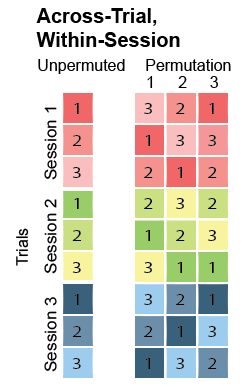

**Figure 5B** in [Vidaurre et al. 2023](https://arxiv.org/abs/2312.07151#:~:text=GLHMM%20is%20implemented%20as%20a,sets%20at%20reasonable%20computational%20time): A 9 x 4 matrix representing permutation testing across trials. Each number corresponds to a trial within a session, and permutations are performed within sessions.


**Hypothesis**
* Null Hypothesis (H0): No significant relationship exists between the independent variables and the dependent variable.
* Alternative Hypothesis (H1): There is a significant relationship between the independent variables and the dependent variable. 



### Across-trials testing - Multivariate <a id="perm-regression"></a>

The multivariate analysis aims to evaluate whether the state time courses of our brain data ($D$) contribute to explaining the observed variability in behavioral measurements ($R$) when viewing inanimate versus animated objects. By quantifying explained variance, this analysis determines whether state transitions significantly influence changes in behavioral responses.

To run the ``test_across_trials`` test, we set the following parameters:

**Inputs**:

* ```D_data```: The state time courses of the brain data (```Gamma_epoch```).
* ```R_data```: The behavioral measurements that is the stimuli condition (```R_trials```).
* ```idx_data``` : Indices for the first and last trial for a given session (```idx_trials_session```)

**Settings**:

* ```method = "multivariate"```: Specifies that the test should perform multivariate analysis.
* ```Nperm```: Number of permutations (optional, default is 1000).

Additional settings allow for the inclusion of confounding variables, which can be regressed out during the permutation testing process. For details on these settings, refer to the function documentation.

In [15]:
# Set the parameters for across sessions within subject testing
method = "multivariate"
Nperm = 1000 # Number of permutations (default = 1000)

# Perform across-trial testing
result_multivariate_trials  =statistics.test_across_trials(D_data=Gamma_epoch, 
                                                           R_data=R_trials, 
                                                           idx_data=idx_trials_session,
                                                           method=method, 
                                                           Nperm=Nperm)

performing permutation testing per timepoint


100%|██████████| 250/250 [01:11<00:00,  3.47it/s]


We can now examine the local ```result_multivaraite_trials``` variable.

In [16]:
result_multivariate_trials

{'pval': array([0.83216783, 0.83216783, 0.83216783, 0.83216783, 0.83216783,
        0.83216783, 0.83216783, 0.3996004 , 0.43656344, 0.56643357,
        0.62737263, 0.50749251, 0.24175824, 0.0989011 , 0.07092907,
        0.05994006, 0.05594406, 0.05994006, 0.05294705, 0.02097902,
        0.01998002, 0.03796204, 0.07792208, 0.14685315, 0.13286713,
        0.04695305, 0.01598402, 0.00599401, 0.003996  , 0.001998  ,
        0.000999  , 0.000999  , 0.000999  , 0.001998  , 0.000999  ,
        0.000999  , 0.000999  , 0.000999  , 0.000999  , 0.000999  ,
        0.000999  , 0.000999  , 0.000999  , 0.000999  , 0.000999  ,
        0.000999  , 0.000999  , 0.000999  , 0.000999  , 0.000999  ,
        0.000999  , 0.000999  , 0.002997  , 0.01498501, 0.04895105,
        0.15384615, 0.22177822, 0.3956044 , 0.37962038, 0.32667333,
        0.18381618, 0.23876124, 0.3986014 , 0.4045954 , 0.5044955 ,
        0.42157842, 0.54545455, 0.45954046, 0.2977023 , 0.10589411,
        0.06993007, 0.05694306, 0.075924

What we can see here is that ```result_multivariate_trials``` is a dictionary containing the outcomes of a statistical analysis conducted using the specified ```method``` and ```test_type```. 

Let us break it down:
* ```pval```: This array holds the p-values resulting from the permutation test. Each value corresponds to a behavioral variable and will have shape of 1 by q, see [GLHMM paper](https://arxiv.org/abs/2312.07151).

* ```base_statistics```: Stores the base statistics of the tests. In this case it is the explained variance $R^2$

* ```test_statistic```: Will by default always return a list of the base (unpermuted) statistics when ```test_statistic_option=False```. This list can store the test statistics associated with the permutation test. It provides information about the permutation distribution that is used to calculate the p-values. The output will exported if we set ```test_statistic_option=True```

* ```statistical_measures```: A dictionary that marks the units used as test_statistics

* ```test_type```: Indicates the type of permutation test performed. In this case, it is ```across_trials```.

* ```method```: Specifies the analytical method employed, which is ```'multivariate'```, which means that the analysis is carried out using regression-based permutation testing.

* ```max_correction```: Boolean value that indicates whether Max correction has been applied when performing permutation testing

* ```Nperm```: Is the number of permutations that has been performed.

* ```test_summary```: A dictionary summarizing the test results based on the applied method.

**Visualization of results**\
Now that we have performed our test, we can then visualize the p-value array.\
We will use the function ```plot_heatmap``` from the ```graphics``` module.

Note: Elements marked in red indicate a p-value below 0.05, signifying statistical significance.

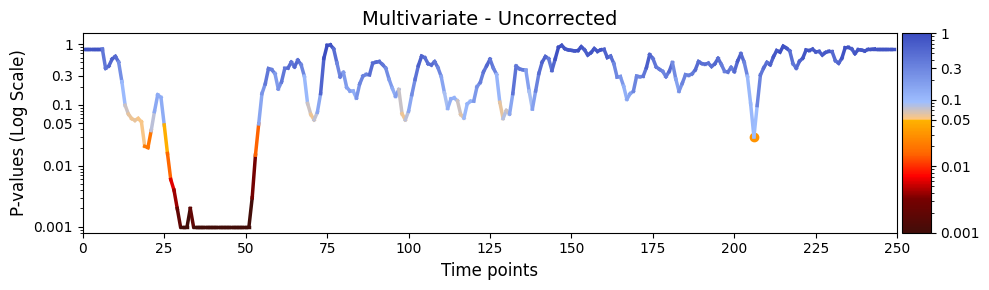

In [17]:
# The alpha score we set for the p-values
alpha = 0.05
# Plot p-values
graphics.plot_p_values_over_time(result_multivariate_trials["pval"], 
                                 title_text ="Multivariate - Uncorrected",
                                 figsize=(10, 3), 
                                 xlabel="Time points", 
                                 alpha=alpha, 
                                 num_x_ticks=11)

**Multiple Comparison**\
To be sure there is no type 1 error, we can apply the Benjamini/Hochberg to control the False Discovery Rate

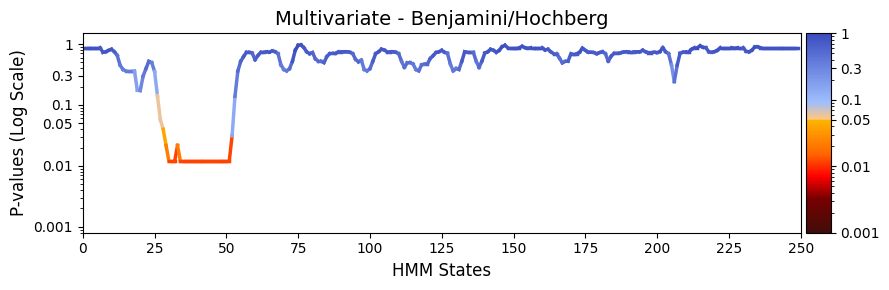

In [18]:
pval_corrected, rejected_corrected =statistics.pval_correction(result_multivariate_trials, 
                                                               method='fdr_bh')
# Plot p-values
graphics.plot_p_values_over_time(pval_corrected, 
                                 title_text ="Multivariate - Benjamini/Hochberg",
                                 figsize=(9, 3), 
                                 xlabel="HMM States", 
                                 num_x_ticks=11)

**Cluster based permutation testing**\
In order to provide a more strict control over Type I mistakes, we can also apply cluster-based permutation testing to control the Family-Wise Error Rate when conducting multiple comparisons.
To use this p-value correction, set ```test_statistics_option=True``` while performing permutation testing, as it is an input to the function (```pval_cluster_based_correction```).

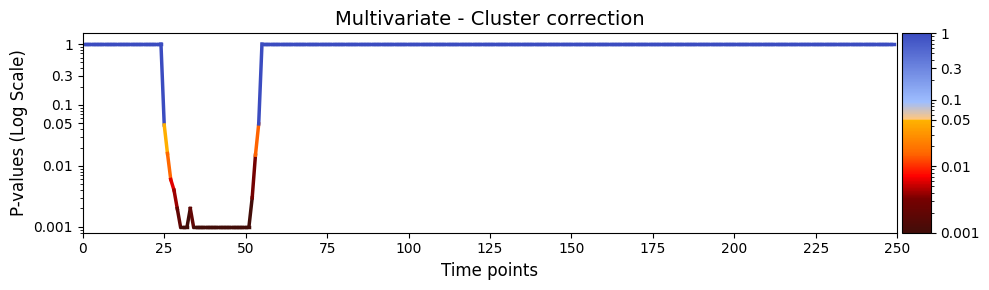

In [19]:
pval_cluster =statistics.pval_cluster_based_correction(result_multivariate_trials)
# Plot p-values
graphics.plot_p_values_over_time(pval_cluster, title_text ="Multivariate - Cluster correction",
                                 figsize=(10, 3), 
                                 xlabel="Time points", 
                                 num_x_ticks=11)

**Visualize average probabilities and differences**\
We can now compare if the results from ```result_multivariate_trials["pval"]``` correspond to the difference for each state over time for the two conditions. This will be done using the function ```plot_condition_difference```.



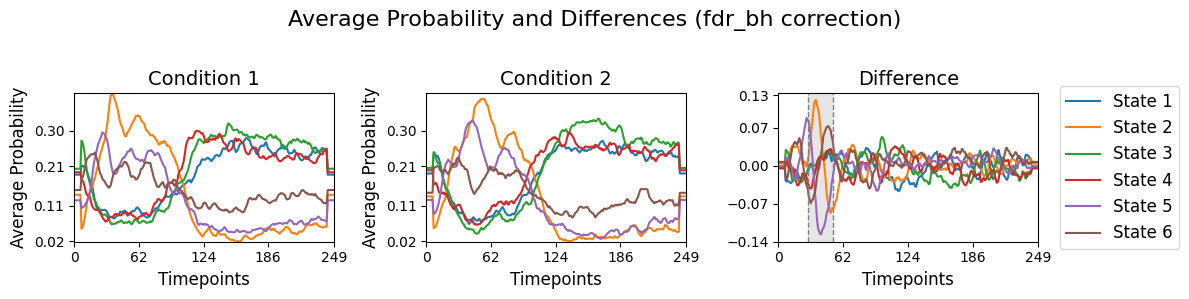

In [20]:
# Detect the intervals of when there is a significant difference, will be highlighed
alpha = 0.05
intervals =statistics.detect_significant_intervals(pval_corrected, alpha)
# Plot the average probability for each state over time for two conditions and their difference.
graphics.plot_condition_difference(Gamma_epoch, 
                                   R_trials, 
                                   figsize=(12,3),
                                   vertical_lines=intervals, 
                                   highlight_boxes=True, 
                                   title="Average Probability and Differences (fdr_bh correction)")

#### Conclusion - Multivariate
The results of the multivariate test on the synthetic data reveal a statistically significant period between 20 and 60 timepoints after applying cluster correction. This indicates that, during this time window, there is a detectable difference in how the simulated subject perceives the stimuli. While these findings are based on synthetic data, they demonstrate the ability of the test to capture meaningful patterns in the simulated brain activity and its relationship with the stimuli.


### Across-trials within sessions testing - Univariate <a id="perm-correlation"></a>
The univariate analysis examines how each state in the brain's activity ($D$, represented by ```Gamma_epoch```) relates to the behavioral measurements ($R$). This method looks for patterns between individual states and the variability in behavioral responses across trials.

If the result is significant, it suggests that certain patterns in the brain's activity (```Gamma_epoch```) are linked to differences in the behavioral measurements, such as responses to different stimuli. A non-significant result means that the observed relationship might be due to chance, and the brain states do not explain the differences in behavior.

To run the test_across_trials, you need to provide the following:

**Inputs**:

* ```D_data```: The state time courses of the brain data (```Gamma_epoch```).
* ```R_data```: The behavioral measurements that is the stimuli condition (```R_trials```).
* ```idx_data``` : Indices for the first and last trial for a given session (```idx_trials_session```)

**Settings**:

* ```method = "univariate"```: Specifies that the test should perform multivariate analysis.
* ```Nperm```: Number of permutations (optional, default is 1000).

You can also adjust for other variables by using permutation testing. For more details, check the function documentation.



In [21]:
# Set the parameters for between-subject testing
method = "univariate"
Nperm = 1000 # Number of permutations (default = 1000)
# Perform across-subject testing
result_univariate  =statistics.test_across_trials(Gamma_epoch, 
                                                  R_trials, 
                                                  idx_trials_session,
                                                  method=method,
                                                  Nperm=Nperm)

performing permutation testing per timepoint


100%|██████████| 250/250 [01:16<00:00,  3.26it/s]


**Visualization of results**\
Now that we have performed our test, we can then visualize the p-value matrix.\
We will use the function ```plot_heatmap``` from the ```graphics``` module.

Note: Elements marked in red indicate a p-value below 0.05, signifying statistical significance.

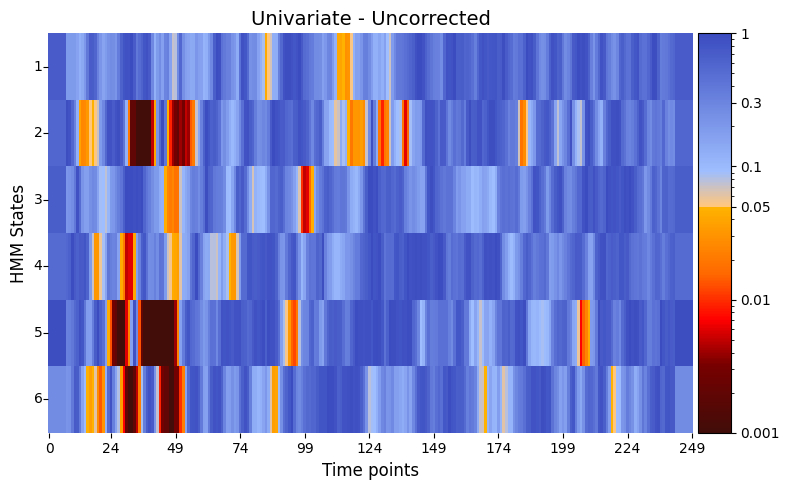

In [22]:
# Plot p-values
alpha = 0.05 # threshold for p-values
graphics.plot_p_value_matrix(result_univariate["pval"].T, 
                             title_text ="Univariate - Uncorrected",
                             figsize=(8, 5), 
                             xlabel="Time points", 
                             ylabel="HMM States", 
                             annot=False, 
                             num_x_ticks=11)


**Multiple Comparison**\
To be sure there is no type 1 error, we can apply the Benjamini/Hochberg to control the False Discovery Rate

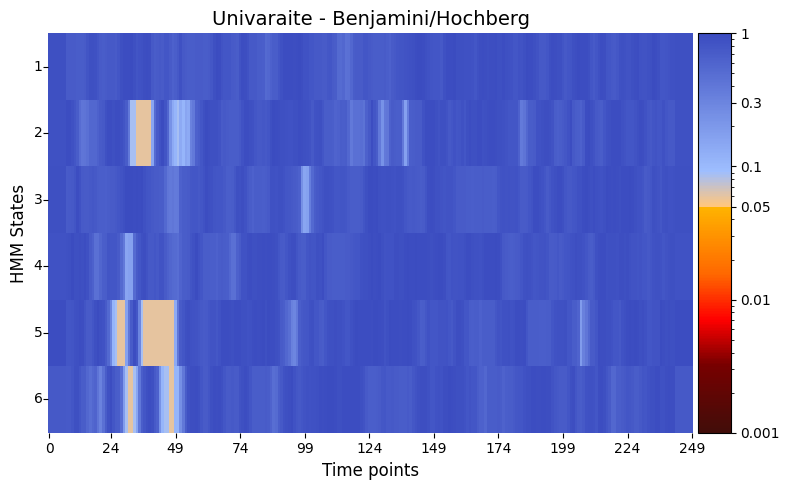

In [23]:
alpha = 0.05 # threshold for p-values
pval_corrected, rejected_corrected =statistics.pval_correction(result_univariate, 
                                                               method='fdr_bh', 
                                                               alpha=0.5)
# Plot p-values
graphics.plot_p_value_matrix(pval_corrected.T, title_text ="Univaraite - Benjamini/Hochberg",
                             figsize=(8, 5), 
                             xlabel="Time points", 
                             ylabel="HMM States", 
                             annot=False, 
                             num_x_ticks=11)

**Cluster based permutation testing**\
In order to provide a more strict control over Type I mistakes, we can also apply cluster-based permutation testing to control the Family-Wise Error Rate when conducting multiple comparisons.

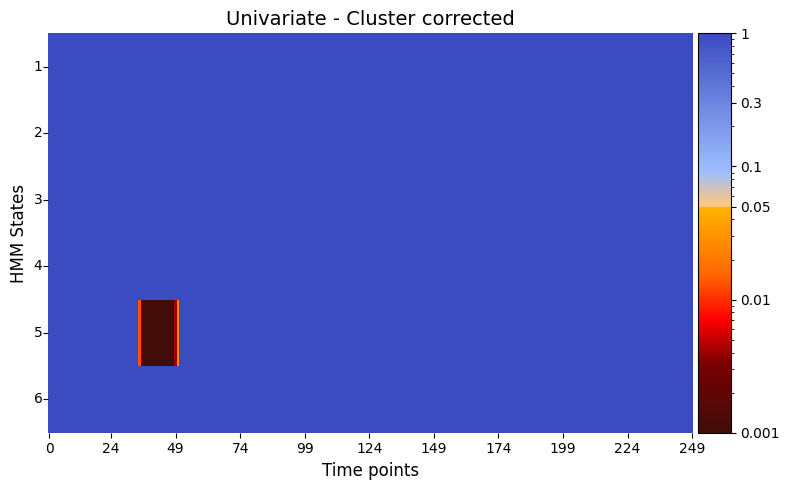

In [24]:
pval_cluster =statistics.pval_cluster_based_correction(result_univariate, individual_feature=True)
# Plot p-values
graphics.plot_p_value_matrix(pval_cluster.T, title_text ="Univariate - Cluster corrected",
                             figsize=(8, 5), 
                             xlabel="Time points", 
                             ylabel="HMM States", 
                             annot=False,
                             num_x_ticks=11,
                             )

Plot Correlation Coefficients

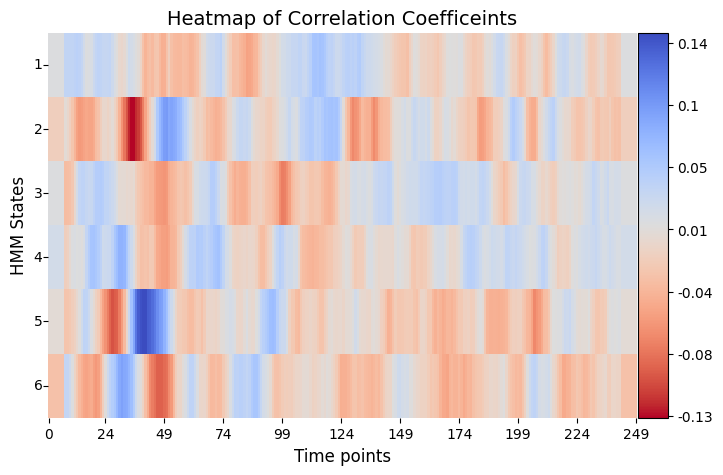

In [25]:
# Plot correlation coefficients
# Correlations between reation time and each state as function of time
graphics.plot_correlation_matrix(result_univariate["base_statistics"].T, 
                                 result_univariate["statistical_measures"], 
                                 title_text ="Heatmap of Correlation Coefficeints",
                                 figsize=(8, 5), 
                                 xlabel="Time points", 
                                 ylabel="HMM States", 
                                 annot=False,
                                 num_x_ticks=11)

#### Conclusion - Univariate test
The results of the univariate test on the synthetic data, after applying cluster correction, reveal distinct periods of significance across different states. For states 2 through 6, significant relationships are observed within the time range of 18–54 timepoints. In state 1, a significant period is identified around 115–120 timepoints, while state 2 also shows additional significance later between 118–122 timepoints. These findings suggest that specific states are associated with varying temporal patterns in the simulated brain activity, reflecting differences in responses to the stimuli.

However, when applying the Benjamini/Hochberg procedure to control for multiple hypotheses, none of the timepoints reach statistical significance. This highlights the challenge of maintaining statistical power in the presence of multiple comparisons and underscores the importance of considering the appropriate correction method for the analysis context.
